In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import numpy as np
import pprint
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.utils import shuffle
from __future__ import print_function
import h5py
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score
import itertools
%matplotlib inline

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
area_labels = ['PM','AL', 'LM', 'V1']


# Calculate Mutual information
mutual information defined as 

In [2]:
#turns out sklearn.metrics.mutual_info_score uses base 10 log rather than base2
#had to write my own implementation of mutual information
#gives similar results to the one from stackoverflow (see below)
# It's not immediately obvious to me how joint prob p(x,y) was computed in that example, 

def computeMI_K(true_label,pred_label,uniform=True):
    #each element of confusion matrix represents the posterior or conditional probability of 
    #predicting a class y' given the true category y - p(y'|y)
    true_value_list = np.unique(true_label) #y
    pred_value_list = np.unique(pred_label) #y'
    
    rows = len(true_value_list)
    cols = len(pred_value_list)
    i_rows = np.arange(0,rows)
    j_cols = np.arange(0,cols)
    p_joint = np.empty((rows,cols))
    prior_py = (1/float(rows))*np.ones((rows)) #assume uniform prior
    mutual_info_sum = 0

    #compute confusion matrix
    cm = confusion_matrix(true_label,pred_label)
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    #calculate joint probability p(y,y')-  equal to product of prior p(y) and 
    #conditional probability p(y'|y) (i.e. elements of confusion matrix)
    p_joint = prior_py[0]*cm
    
    if uniform is False:
        prior_py = np.array([ len(true_label[true_label==val])/float(len(true_label)) for val in true_value_list ]) #P(y)
        for i in i_rows:
            for j in j_cols:
                p_joint[i,j] = prior_py[i]*cm[i,j]
            
    #calculate p(y') -i.e. sum joint probability p(y,y') over true label y
    p_y_p = np.sum(p_joint,axis=0)

    #calculate mutual information
    MI = 0.0
    for i in i_rows:
        for j in j_cols:
            if p_joint[i,j] == 0:
                continue
            if p_y_p[j] ==0: 
                continue
            MI += p_joint[i,j]*np.log2((p_joint[i,j])/(prior_py[i]*p_y_p[j]))
    return MI

#compute mutual information- obtained from stackoverflow 
#https://stackoverflow.com/questions/24686374/pythons-implementation-of-mutual-information
#turns out sklearn.metrics.mutual_info_score uses base 10 log rather than base2  
def computeMI(x, y):
    
    mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)

    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return mi

# Confusion matrix and mutual information - data

VISpm, mean test accuracy: 31.80 (+/- 2.34)
VISpm Mutual info: 2.92 bits (+/- 0.18)
VISal, mean test accuracy: 34.19 (+/- 0.91)
VISal Mutual info: 2.94 bits (+/- 0.12)
VISl, mean test accuracy: 51.21 (+/- 1.17)
VISl Mutual info: 3.93 bits (+/- 0.21)
VISp, mean test accuracy: 74.12 (+/- 1.40)
VISp Mutual info: 5.38 bits (+/- 0.12)


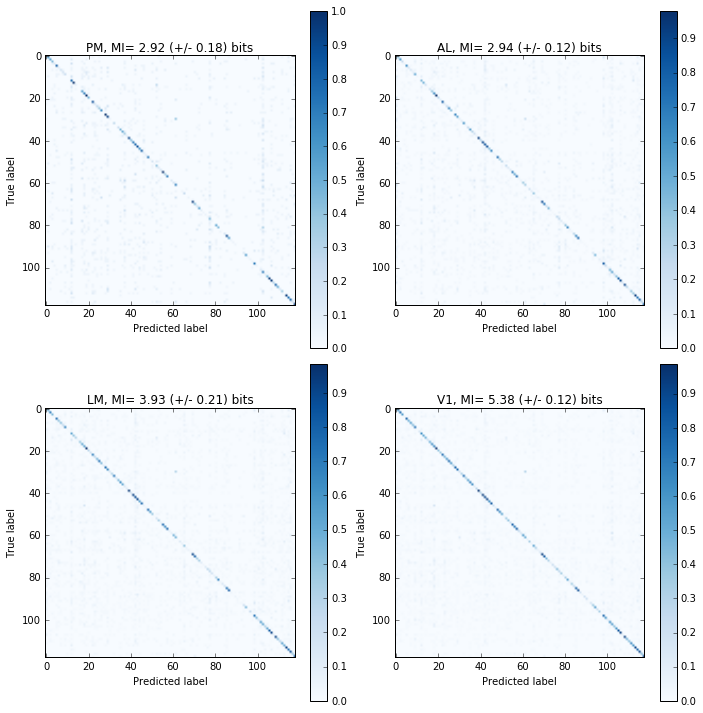

In [29]:
fig = plt.figure(figsize=(10,10))
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
#first 7 frames before stimulus, 7 stimulus ON frames followed by 7 frames post stimulus.
#please note that in the actual experiment there was no 
#blank period between frames, i.e. stimuli were presented consecutively. 
stim_onset = 7 #occurs after first 7 frames
stim_frames = 7

niter = 5     #run classifier. repeat 10x and average
num_cells_per_area = list()
limit_num_neurons = 0
single_frame = 0
scale = 1
add_to_filename = '_all_neurons'

if limit_num_neurons:
    num_neurons_include = 2100 
    add_to_filename = '_2100_neurons'
        
for aa in range(len(areas)):
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    #load hdf5 file
    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        X = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
    
    XT_ALL = X[50:,:,:] #first 50 trials belongs to blank, ignore 
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore 
    y_shuffle = shuffle(y)
    
    #select range approximately 200 to 300ms from stimulus onset
    X_train_range = XT_ALL[:,:,stim_onset+6:stim_onset+10] 
    #compute mean
    X_ALL = np.mean(X_train_range,axis=2)
    
    if single_frame: #pick single frame
        #stim_onset+6 = approx 200ms post stimulus onset, stim_onset+9 ~approx 300ms post stim
        X_ALL = XT_ALL[:,:,stim_onset+6] 
        add_to_filename = '_single_frame' + add_to_filename
        
    num_cells_per_area.append(X.shape[1])
    accuracy_per_iter = list()    
    num_neurons_include = X.shape[1]
    accuracy_per_iter_shuffle = list()
    mutual_info_per_iter = list()

    for ii in range(niter):
        inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
        Xn = X_ALL[:,inds]

        #for cross validation do, 70/30 split.
        X_train,X_test,y_train,y_test = train_test_split(Xn,y,test_size=0.4) 

        #scale each feature [0,1]
        if scale:
            scaler = preprocessing.MinMaxScaler()
            X_train_scale = scaler.fit_transform(X_train)
            X_test_scale = scaler.fit_transform(X_test)
        else:
            #normalize the response of each neuron to zero mean and unit variance
            #uses a lot of memory when using standardscaler. consider running on faster machine
            mean_X_train = np.mean(X_train,axis=0)
            std_X_train = np.std(X_train,axis=0)
            X_train_scale = (X_train - mean_X_train) / std_X_train
            X_test_scale = (X_test - mean_X_train) / std_X_train
            
        # train linear SVM classifier on data
        linearSVM_1 = OneVsRestClassifier(LinearSVC(C=0.0163))
        y_pred = linearSVM_1.fit(X_train_scale, y_train).predict(X_test_scale)
        
        accuracy_per_iter.append(100*linearSVM_1.score(X_test_scale,y_test))
        mutual_info_per_iter.append(computeMI_K(y_test,y_pred))
        
    mean_accuracy = np.mean(np.array(accuracy_per_iter))
    ci_accuracy = np.std(np.array(accuracy_per_iter)) / np.sqrt(niter)   
    print(this_area + ', mean test accuracy: %0.2f (+/- %0.2f)' %(mean_accuracy,ci_accuracy))

    mutual_info = np.mean(np.array(mutual_info_per_iter))
    ci_mutual_info = np.std(np.array(mutual_info_per_iter))/np.sqrt(niter)
    print(this_area + ' Mutual info: %0.2f bits (+/- %0.2f)' %(mutual_info,ci_mutual_info))

    if aa == 0:
        mean_accuracy_per_area = mean_accuracy
        ci_accuracy_per_area = ci_accuracy
        
        mutual_info_per_area = mutual_info
        ci_mutual_info_per_area = ci_mutual_info
        
        y_test_all = y_test
        y_pred_all = y_pred
    if aa > 0:
        mean_accuracy_per_area = np.vstack((mean_accuracy_per_area,mean_accuracy))
        ci_accuracy_per_area = np.vstack((ci_accuracy_per_area,ci_accuracy))
        
        mutual_info_per_area = np.vstack((mutual_info_per_area,mutual_info))
        ci_mutual_info_per_area = np.vstack((ci_mutual_info_per_area,ci_mutual_info))
        
        y_test_all = np.hstack((y_test_all,y_test))
        y_pred_all = np.hstack((y_pred_all,y_pred))
    
    #compute confusion matrix 
    cm = confusion_matrix(y_test_all,y_pred_all)
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis] #normalize

    #plot confusion matrix
    title=(area_labels[aa] + ', MI= %0.2f (+/- %0.2f) bits' %(mutual_info,ci_mutual_info))
    plt.subplot(2,2,aa+1)
    plt.imshow(cm,cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#print figure to PDF
with PdfPages('Confusion Matrix'+ add_to_filename +'.pdf') as pdf:
    pdf.savefig(fig)

# mutual information per network size

In [44]:
percentages = np.array([0.05,1,5, 10, 25, 50, 75, 100])
num_neurons_list =list((total_num_cells * percentages/float(100)).astype(int))
num_neurons_list

[1, 21, 107, 215, 539, 1078, 1617, 2157]

In [58]:
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
#first 7 frames before stimulus, 7 stimulus ON frames followed by 7 frames post stimulus.
#please note that in the actual experiment there was no 
#blank period between frames, i.e. stimuli were presented consecutively. 
stim_onset = 7 #occurs after first 7 frames
stim_frames = 7

niter = 5     #run classifier. repeat 10x and average
num_cells_per_area = list()
scale = 1
add_to_filename = '_all_neurons'
percentages = np.array([0.05,1,5, 10, 25, 50, 75, 100])
    
for aa in range(len(areas)):
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    #load hdf5 file
    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        X = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
    
    XT_ALL = X[50:,:,:] #first 50 trials belongs to blank, ignore 
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore 
    y_shuffle = shuffle(y)
    
    #select range approximately 200 to 300ms from stimulus onset
    X_train_range = XT_ALL[:,:,stim_onset+6:stim_onset+10] 
    #compute mean
    X_ALL = np.mean(X_train_range,axis=2)
        
    num_cells_per_area.append(X.shape[1])
    total_num_cells = X.shape[1]
    num_neurons_list =list((total_num_cells * percentages/float(100)).astype(int))

    for ii in range(niter):
        accuracy_per_size = list()
        mutual_info_per_size = list()
        
        for nn in range(len(num_neurons_list)):
            this_num_neurons = num_neurons_list[nn]
            inds = np.random.randint(0,total_num_cells,(this_num_neurons,))
            Xn = X_ALL[:,inds]

            #for cross validation do, 70/30 split.
            X_train,X_test,y_train,y_test = train_test_split(Xn,y,test_size=0.4) 

            #scale each feature [0,1]
            if scale:
                scaler = preprocessing.MinMaxScaler()
                X_train_scale = scaler.fit_transform(X_train)
                X_test_scale = scaler.fit_transform(X_test)
            else:
                #normalize the response of each neuron to zero mean and unit variance
                #uses a lot of memory when using standardscaler. consider running on faster machine
                mean_X_train = np.mean(X_train,axis=0)
                std_X_train = np.std(X_train,axis=0)
                X_train_scale = (X_train - mean_X_train) / std_X_train
                X_test_scale = (X_test - mean_X_train) / std_X_train

            # train linear SVM classifier on data
            linearSVM_1 = OneVsRestClassifier(LinearSVC(C=0.0163))
            y_pred = linearSVM_1.fit(X_train_scale, y_train).predict(X_test_scale)

            accuracy_per_size.append(100*linearSVM_1.score(X_test_scale,y_test))
            mutual_info_per_size.append(computeMI_K(y_test,y_pred))
        
        if ii == 0:
            accuracy_per_iter = np.array(accuracy_per_size)
            mutual_info_per_iter = np.array(mutual_info_per_size)
        else:
            accuracy_per_iter = np.vstack((accuracy_per_iter,np.array(accuracy_per_size)))
            mutual_info_per_iter = np.vstack((mutual_info_per_iter,np.array(mutual_info_per_size)))
            
    mean_accuracy = np.mean(accuracy_per_iter,axis=0)
    ci_accuracy = np.std(accuracy_per_iter,axis=0) / np.sqrt(niter)   
    #print(this_area + ', mean test accuracy: %0.2f (+/- %0.2f)' %(mean_accuracy,ci_accuracy))
    print(this_area)
    print(mean_accuracy)
    mutual_info = np.mean(np.array(mutual_info_per_iter),axis=0)
    ci_mutual_info = np.std(np.array(mutual_info_per_iter),axis=0)/np.sqrt(niter)
    #print(this_area + ' Mutual info: %0.2f bits (+/- %0.2f)' %(mutual_info,ci_mutual_info))
    print(mutual_info)
    
    if aa == 0:
        mean_accuracy_per_area = mean_accuracy
        ci_accuracy_per_area = ci_accuracy
        
        mutual_info_per_area = mutual_info
        ci_mutual_info_per_area = ci_mutual_info
        
        master_list = np.array(num_neurons_list)
    else:
        mean_accuracy_per_area = np.vstack((mean_accuracy_per_area,mean_accuracy))
        ci_accuracy_per_area = np.vstack((ci_accuracy_per_area,ci_accuracy))
        
        mutual_info_per_area = np.vstack((mutual_info_per_area,mutual_info))
        ci_mutual_info_per_area = np.vstack((ci_mutual_info_per_area,ci_mutual_info))
        master_list = np.vstack((master_list,np.array(num_neurons_list)))

VISpm
[  0.54237288   1.71186441   6.46610169   8.6440678   16.27966102
  24.56779661  28.83050847  31.60169492]
[ 0.00731189  0.470503    1.44320723  1.43466656  1.95021243  2.41297218
  2.96257813  2.93329279]
VISal
[  0.83898305   2.72033898   6.63559322  10.48305085  18.79661017
  25.20338983  30.83050847  34.58474576]
[ 0.01250083  0.5188148   1.13103869  1.34140825  2.08107379  2.36540152
  2.6757857   3.06804909]
VISl
[  0.72033898   3.3559322    9.73728814  16.36440678  28.90677966
  41.18644068  46.22033898  49.88983051]
[ 0.00787842  0.43206693  1.28823213  1.62918845  2.49665986  3.15796981
  3.70421221  3.94164682]
VISp
[  0.94067797   5.70338983  16.50847458  30.6779661   49.89830508  67.
  72.61016949  74.02542373]
[ 0.01725005  0.80084856  1.67499417  2.6264515   3.86350392  4.92541542
  5.33092606  5.27318949]


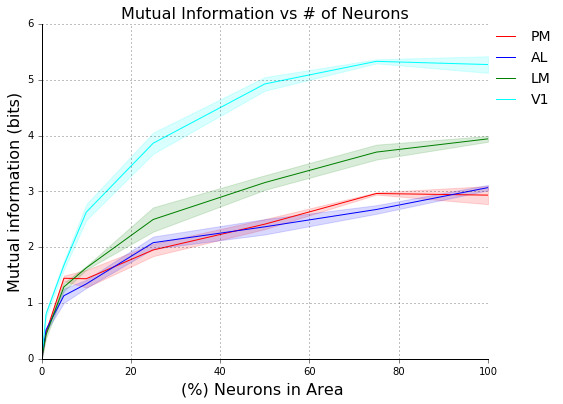

In [64]:
#make pretty plots
colors = ['red','blue','green','cyan']

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')

ax.set_ylim(0,6)
plt.ylabel('Mutual information (bits)',fontsize=16)
plt.xlabel('(%) Neurons in Area ', fontsize=16)
plt.title( 'Mutual Information vs # of Neurons',fontsize=16)

for aa in range(len(areas)):
    plt.plot(percentages,mutual_info_per_area[aa,:],ls='-',label=area_labels[aa],color=colors[aa])
    upper = mutual_info_per_area[aa,:] + ci_mutual_info_per_area[aa,:]
    lower = mutual_info_per_area[aa,:] - ci_mutual_info_per_area[aa,:]
    plt.fill_between(percentages,lower,upper,alpha=0.15,color=colors[aa])
    
plt.legend(bbox_to_anchor=(0.995, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=14)
#plt.yticks([0, 25 ,50,75, 100])
plt.grid()

with PdfPages('Mutual information per number neurons per visual area' + add_to_filename + '.pdf') as pdf:
    pdf.savefig(fig)


# confusion matrix and mutual information - shuffle

In [ ]:
fig = plt.figure(figsize=(10,10))
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
#first 7 frames before stimulus, 7 stimulus ON frames followed by 7 frames post stimulus.
#please note that in the actual experiment there was no 
#blank period between frames, i.e. stimuli were presented consecutively. 
stim_onset = 7 #occurs after first 7 frames
stim_frames = 7

niter = 1     #run classifier. repeat 10x and average
num_cells_per_area = list()
limit_num_neurons = 0
single_frame = 0
scale = 1
add_to_filename = 'all_neurons'

if limit_num_neurons:
    num_neurons_include = 2100 
    add_to_filename = '_2100_neurons'
        
for aa in range(len(areas)):
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    #load hdf5 file
    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        X = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
    
    XT_ALL = X[50:,:,:] #first 50 trials belongs to blank, ignore 
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore 
    y_shuffle = shuffle(y)
    
    #select range approximately 200 to 300ms from stimulus onset
    X_train_range = XT_ALL[:,:,stim_onset+6:stim_onset+10] 
    #compute mean
    X_ALL = np.mean(X_train_range,axis=2)
    
    if single_frame: #pick single frame
        #stim_onset+6 = approx 200ms post stimulus onset, stim_onset+9 ~approx 300ms post stim
        X_ALL = XT_ALL[:,:,stim_onset+6] 
        add_to_filename = '_single_frame' + add_to_filename
        
    num_cells_per_area.append(X.shape[1])
    accuracy_per_iter = list()    
    num_neurons_include = X.shape[1]
    accuracy_per_iter_shuffle = list()
    for ii in range(niter):
        inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
        Xn = X_ALL[:,inds]
        y = shuffle(y)
        #for cross validation do, 70/30 split.
        X_train,X_test,y_train,y_test = train_test_split(Xn,y,test_size=0.4) 

        #scale each feature [0,1]
        if scale:
            scaler = preprocessing.MinMaxScaler()
            X_train_scale = scaler.fit_transform(X_train)
            X_test_scale = scaler.fit_transform(X_test)
        else:
            #normalize the response of each neuron to zero mean and unit variance
            #uses a lot of memory when using standardscaler. consider running on faster machine
            mean_X_train = np.mean(X_train,axis=0)
            std_X_train = np.std(X_train,axis=0)
            X_train_scale = (X_train - mean_X_train) / std_X_train
            X_test_scale = (X_test - mean_X_train) / std_X_train
            
        # train linear SVM classifier on shuffled data
        linearSVM_1 = OneVsRestClassifier(LinearSVC(C=0.0163))
        y_pred = linearSVM_1.fit(X_train_scale, y_train).predict(X_test_scale)
        accuracy_per_iter.append(100*linearSVM_1.score(X_test_scale,y_test))
       
    mean_accuracy = np.mean(np.array(accuracy_per_iter))
    std_accuracy = np.std(np.array(accuracy_per_iter)) / np.sqrt(niter)   
    
    print(this_area + ', mean shuffle accuracy: %0.2f (+/- %0.2f)' %(mean_accuracy,std_accuracy))

    if aa == 0:
        mean_accuracy_per_area = mean_accuracy
        std_accuracy_per_area = std_accuracy
        
    if aa > 0:
        mean_accuracy_per_area = np.vstack((mean_accuracy_per_area,mean_accuracy))
        std_accuracy_per_area = np.vstack((std_accuracy_per_area,std_accuracy))
    
    #compute confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    np.set_printoptions(precision=2)
    mutual_info = computeMI_K(y_test,y_pred)
    print(this_area + ' Mutual info: %0.2f bits ' %(mutual_info))
    
    #plot confusion matrix
    title=(area_labels[aa] + ', MI= %0.2f bits' %(mutual_info))
    plt.subplot(2,2,aa+1)
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    plt.imshow(cm,cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#print figure to PDF
with PdfPages('Confusion Matrix'+ add_to_filename +'-shuffle.pdf') as pdf:
    pdf.savefig(fig)